# Imports

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import balanced_accuracy_score

In [3]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
!pip install statannot

from statannot import add_stat_annotation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# EDA

In [5]:
data = pd.read_csv('/content/Meta-dataset.csv')
data

,Name,Model,Sector,CO_Embed2_Dist_tau_d_expfit_meandiff,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_f1ecac,CO_trev_1_num,DN_HistogramMode_10,DN_HistogramMode_5,...,w_lambda,Model_ACC,acc_ADA,acc_DT,acc_KNN,acc_NB,acc_RF,acc_LogReg,acc_SVM,acc_XGB
0,ADN,NB,Utilities,1.005129,113.0,0.821879,62.0,0.001890,-0.072511,0.235658,...,0.972697,DT,0.497960,0.518847,0.487627,0.508106,0.511725,0.500000,0.500000,0.493018
1,AQN,LogReg,Utilities,1.268842,817.0,1.179140,319.0,-0.000563,-0.758271,-0.562710,...,0.997704,XGB,0.494913,0.500635,0.498634,0.489901,0.505009,0.500000,0.494930,0.524556
2,ALE,XGB,Utilities,0.739080,265.0,1.140440,125.0,-0.000647,-0.736042,-0.944629,...,0.994538,XGB,0.517775,0.508174,0.512319,0.518041,0.513361,0.500000,0.515728,0.520300
3,LNT,SVM,Utilities,1.474446,280.0,1.155608,254.0,-0.000120,-0.643060,-1.242982,...,0.990864,SVM,0.506857,0.496997,0.514614,0.490736,0.504166,0.500000,0.517081,0.503879
4,AEE,NB,Utilities,1.027392,524.0,1.151072,306.0,-0.000220,0.483946,0.277988,...,0.993470,ADA,0.517475,0.510824,0.508657,0.513339,0.517316,0.500000,0.514110,0.513809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,MOBL,RF,Information Technology,0.590554,167.0,0.927771,73.0,-0.003164,-0.390130,-0.136427,...,0.987922,RF,0.480388,0.485160,0.483767,0.499659,0.508809,0.500000,0.499387,0.497683
4411,NUAN,KNN,Information Technology,2.064166,798.0,0.963382,239.0,0.000089,-0.686908,-0.541718,...,0.996897,RF,0.510107,0.508861,0.510376,0.500584,0.515463,0.499178,0.499720,0.497028
4412,TACO,ADA,Consumer Discretionary,0.470783,341.0,0.951523,140.0,0.003909,0.790727,0.516555,...,0.993727,XGB,0.514219,0.508371,0.511327,0.495742,0.492713,0.500000,0.498064,0.533231
4413,ZNGA,RF,Communication Services,1.055821,897.0,1.124543,307.0,0.000361,-0.785611,-0.972417,...,0.998747,RF,0.512421,0.494841,0.518349,0.489801,0.536638,0.500000,0.507163,0.513762


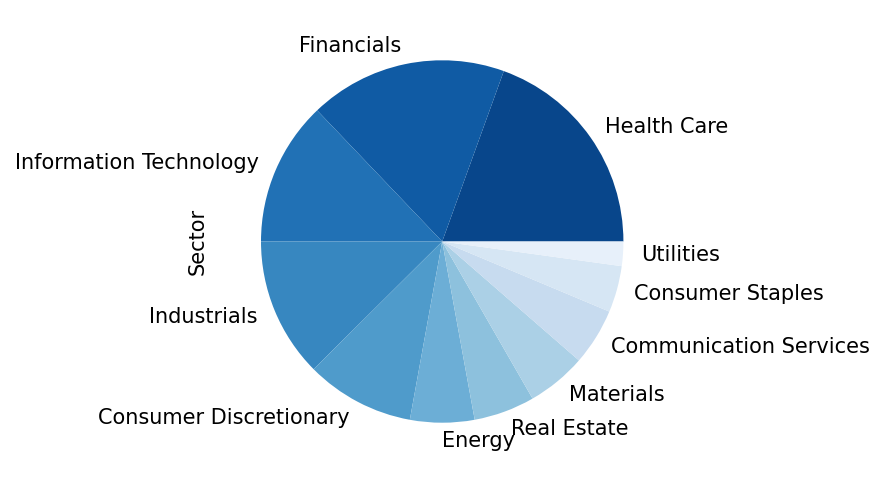

In [7]:
plt.rcParams["figure.dpi"] = 150
data.Sector.value_counts().plot(kind='pie', colors=sns.color_palette("Blues_r",11), label="Sector")

## For BAC

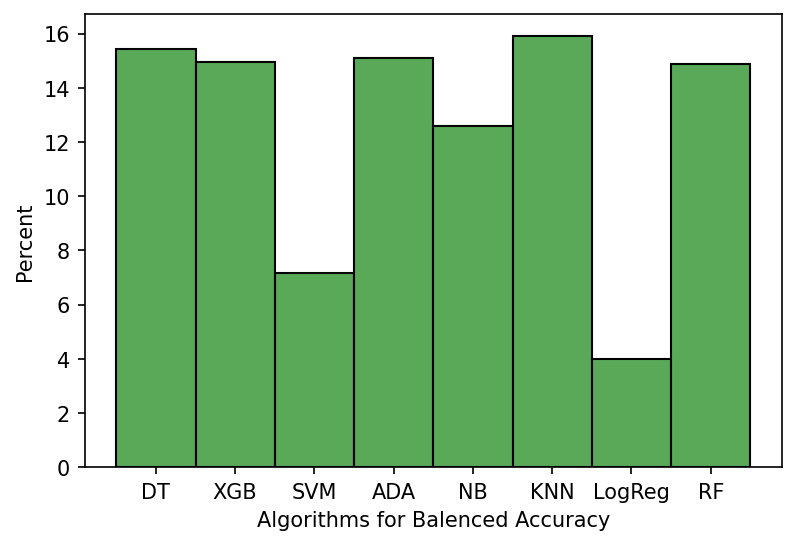

In [8]:
plt.figure(figsize=(6,4), dpi=150)
sns.histplot(data['Model_ACC'], stat='percent', color='#228C22')
plt.xlabel("Algorithms for Balenced Accuracy")
plt.show()

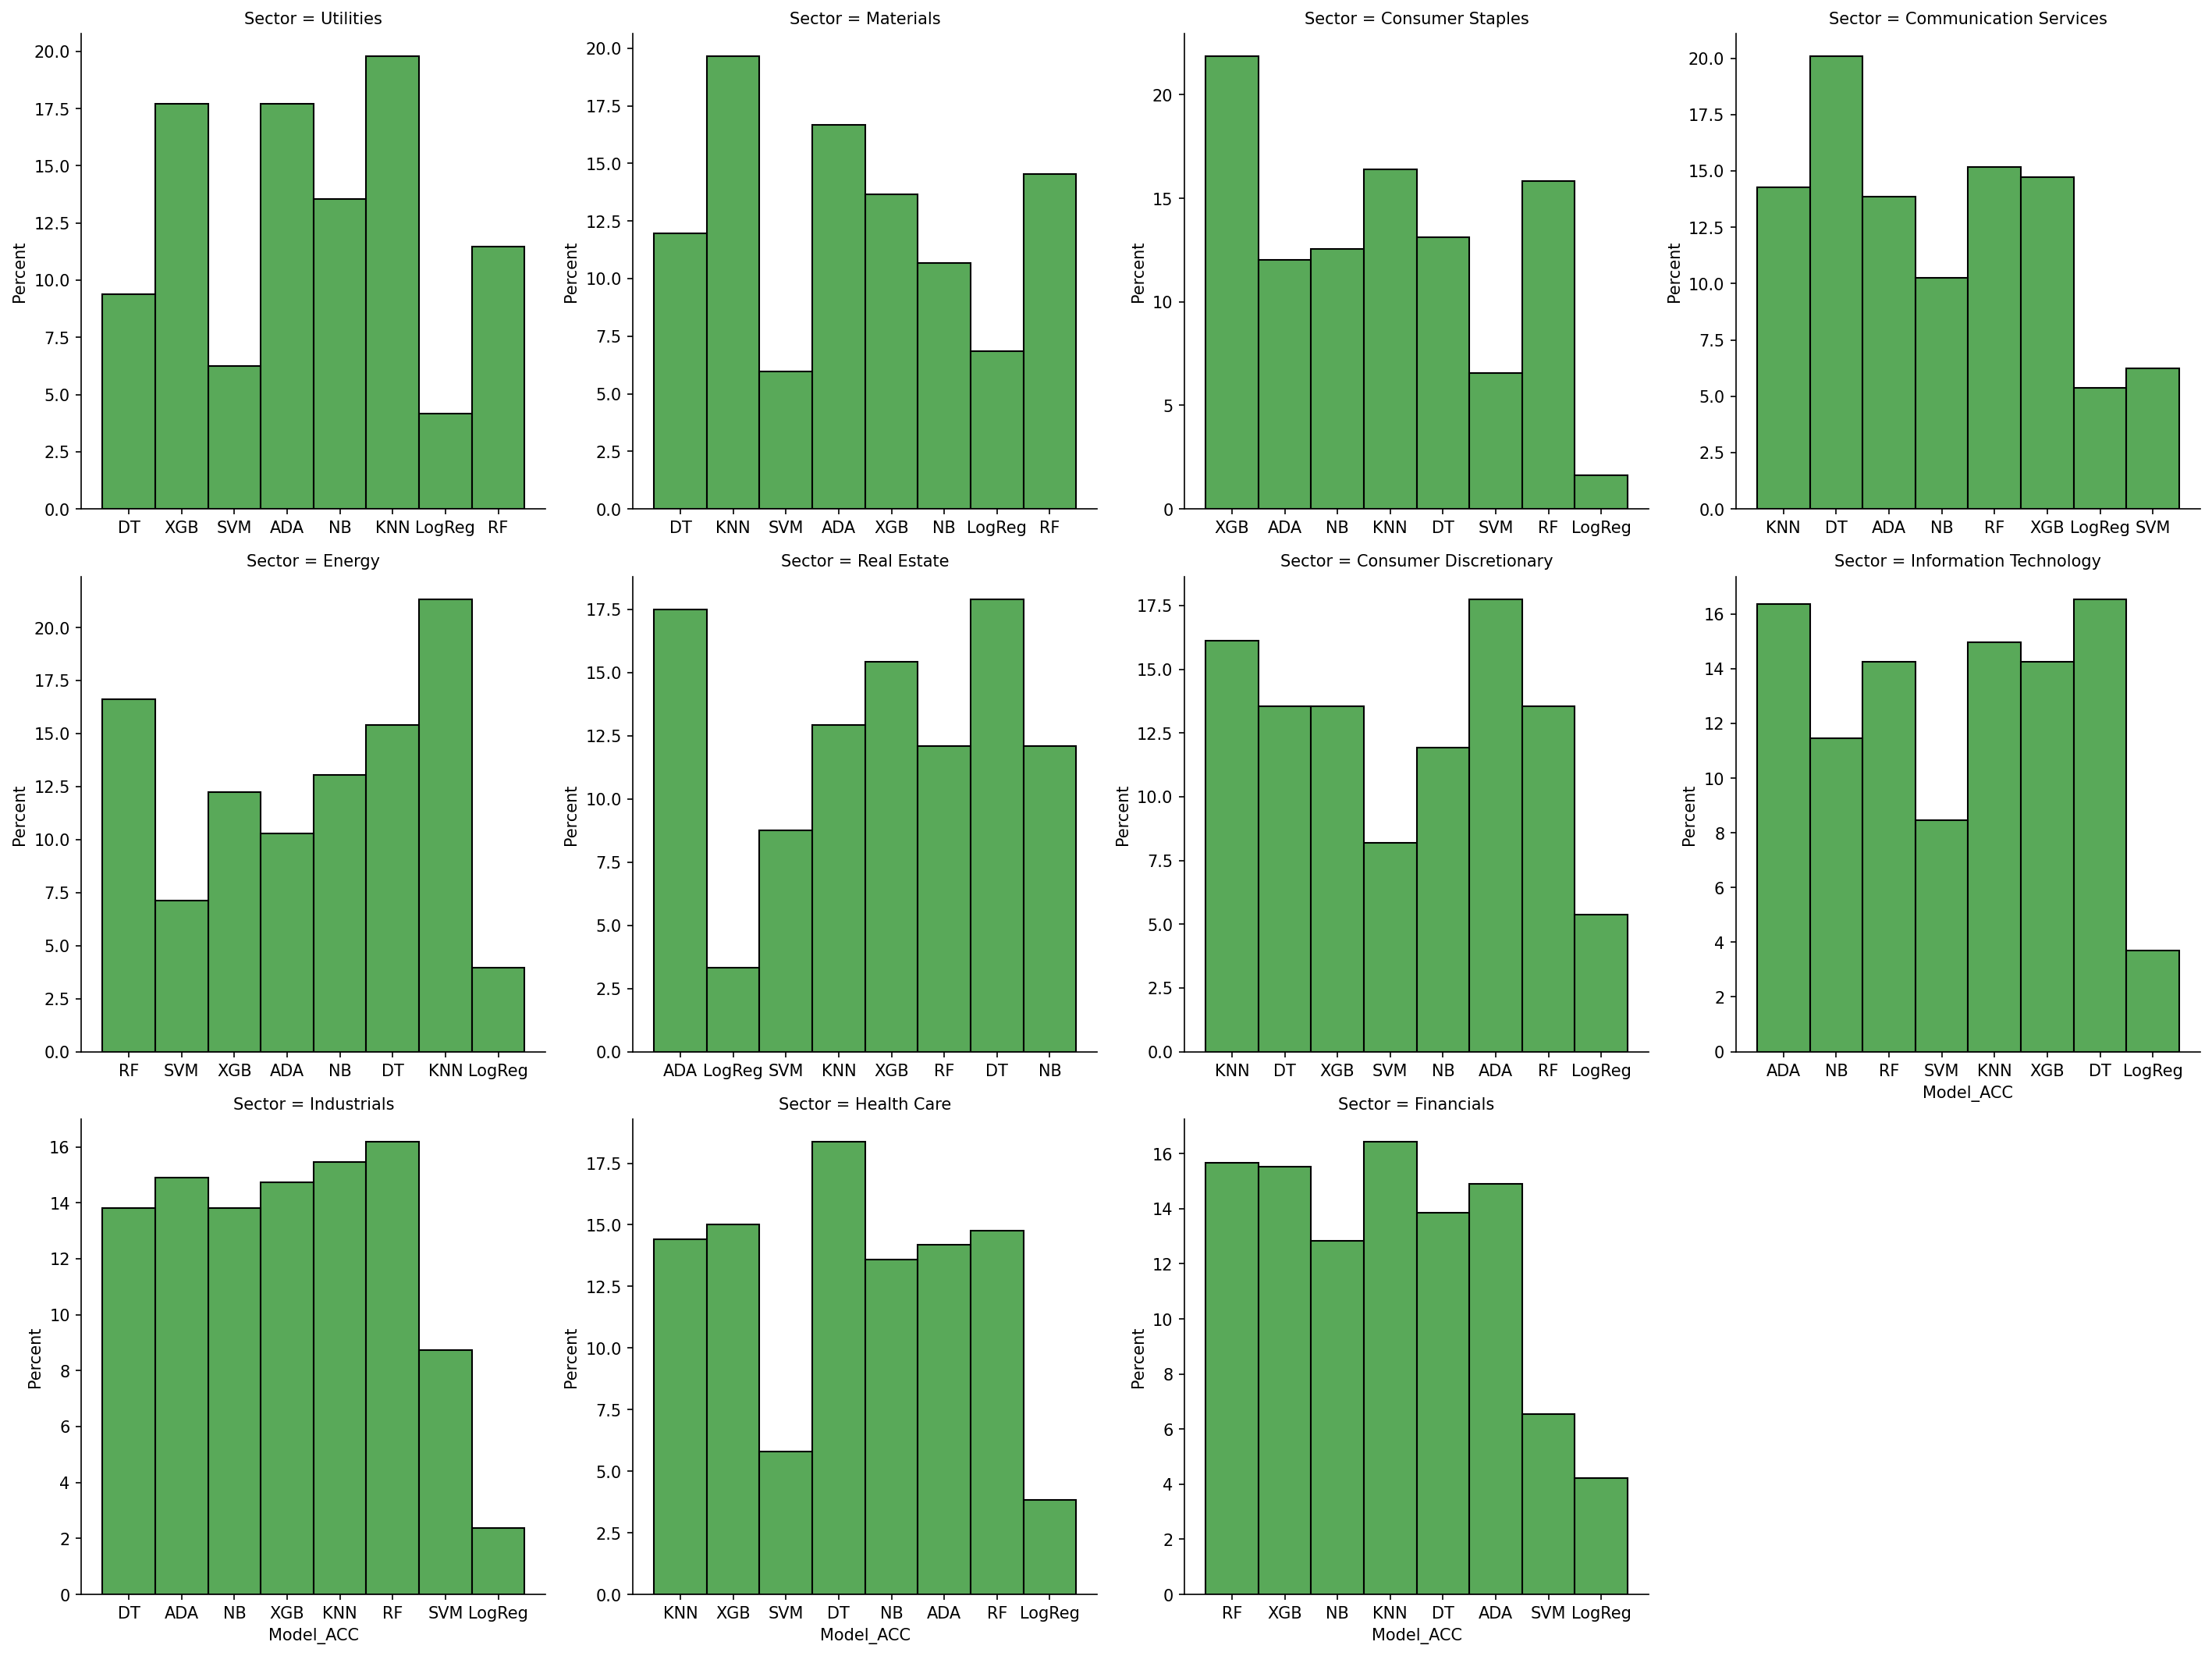

In [9]:
g = sns.FacetGrid(data, col="Sector", col_wrap=4, sharex=False, sharey=False, height=4.75)
g.map(sns.histplot, "Model_ACC", stat='percent', color='#228C22')

## For CRet

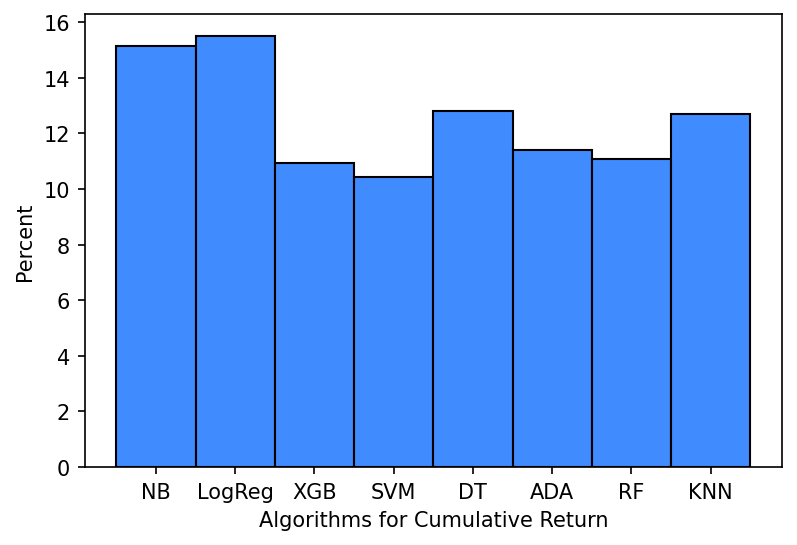

In [10]:
plt.figure(figsize=(6,4), dpi=150)
sns.histplot(data['Model'], stat='percent', color='#0066FF')
plt.xlabel("Algorithms for Cumulative Return")
plt.show()

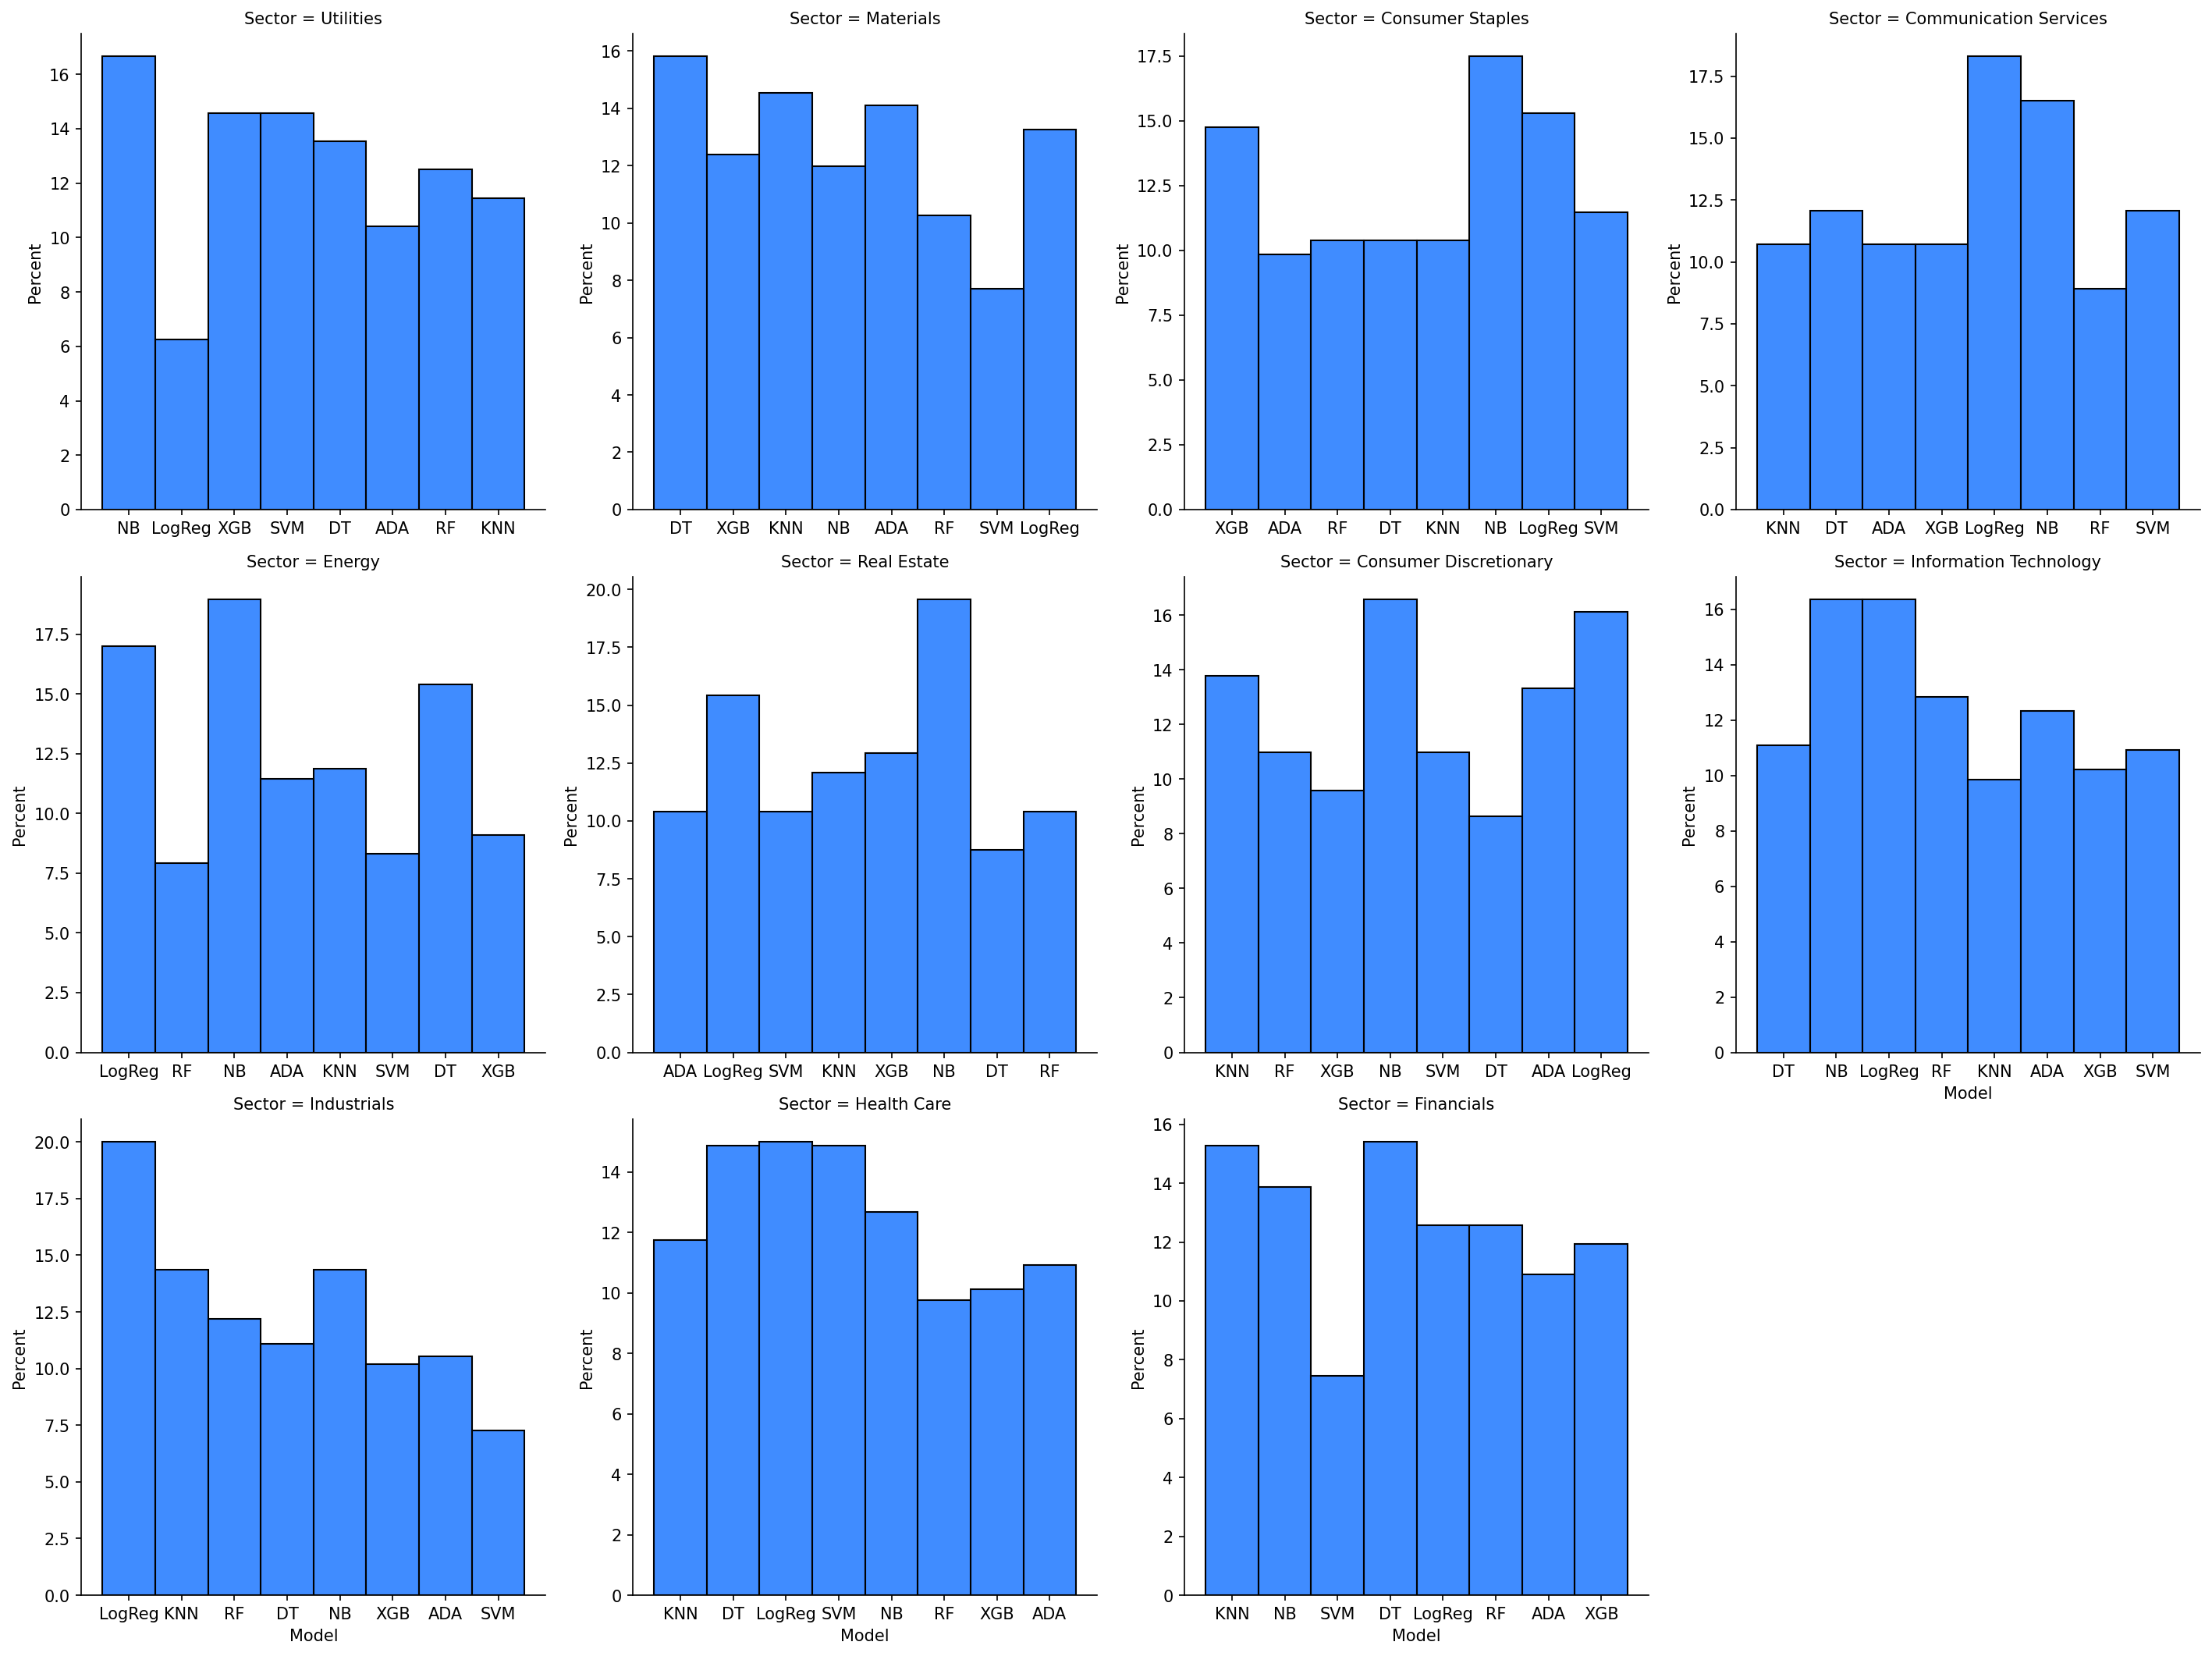

In [11]:
g = sns.FacetGrid(data, col="Sector", col_wrap=4, sharex=False, sharey=False, height=4.75)
g.map(sns.histplot, "Model", stat='percent', color='#0066FF')

# Meta level evaluation

In [13]:
X_ret = data.drop(columns=['Name', 'Model','Model_ACC', 'Sector','Starting_date','Closing_date', 
                             'acc_ADA', 'acc_DT', 'acc_KNN', 'acc_NB', 'acc_RF', 'acc_LogReg', 'acc_SVM', 'acc_XGB', 
                             'ret_ADA', 'ret_DT', 'ret_KNN', 'ret_NB', 'ret_RF', 'ret_LogReg', 'ret_SVM', 'ret_XGB'], axis=1)
y_ret = data['Model'] #CRet target
y_acc = data['Model_ACC'] #BAC target

#scaling data
scale = MinMaxScaler()
X_ret_scaled = scale.fit_transform(X_ret)
X_ret = pd.DataFrame(X_ret_scaled, index=X_ret.index, columns=X_ret.columns)

X_ret

,CO_Embed2_Dist_tau_d_expfit_meandiff,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_f1ecac,CO_trev_1_num,DN_HistogramMode_10,DN_HistogramMode_5,DN_OutlierInclude_n_001_mdrmd,DN_OutlierInclude_p_001_mdrmd,FC_LocalSimple_mean1_tauresrat,...,sd.sd,skewness.mean,skewness.sd,sparsity.mean,sparsity.sd,t_mean.mean,t_mean.sd,var.mean,var.sd,w_lambda
0,0.189335,0.086410,0.572219,0.158774,0.239781,0.478160,0.512397,0.978734,0.632120,0.158515,...,0.060610,0.409662,0.728385,0.030909,0.008849,0.001536,0.001535,6.980033e-04,3.375256e-03,0.902015
1,0.241255,0.639434,0.827529,0.874652,0.238892,0.246253,0.269462,0.122925,0.806375,0.006196,...,0.012615,0.207895,0.242167,0.015670,0.008797,0.003631,0.003630,3.023568e-05,1.462073e-04,0.992331
2,0.136956,0.205813,0.799874,0.334262,0.238861,0.253771,0.153247,0.713176,0.536792,0.051037,...,0.002815,0.343851,0.536574,0.003485,0.001155,0.002137,0.002133,1.505855e-06,7.281693e-06,0.980894
3,0.281733,0.217596,0.810713,0.693593,0.239053,0.285215,0.062461,0.121159,0.905053,0.004350,...,0.015489,0.460254,0.714072,0.004175,0.002374,0.011392,0.011390,4.558799e-05,2.204447e-04,0.967626
4,0.193718,0.409269,0.807472,0.838440,0.239016,0.666340,0.525277,0.117980,0.894201,0.005170,...,0.006893,0.093254,0.062557,0.002500,0.001296,0.012506,0.012502,9.027492e-06,4.365323e-05,0.977039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,0.107714,0.128830,0.647894,0.189415,0.237949,0.370749,0.399175,0.271635,0.026280,0.091520,...,0.011590,0.355794,0.360598,0.027776,0.013460,0.004549,0.004549,2.552257e-05,1.234166e-04,0.957000
4411,0.397837,0.624509,0.673342,0.651811,0.239128,0.270387,0.275849,0.312964,0.902679,0.015439,...,0.041863,0.344380,0.346414,0.008814,0.004238,0.025593,0.025592,3.329970e-04,1.610236e-03,0.989416
4412,0.084134,0.265515,0.664868,0.376045,0.240513,0.770086,0.597871,0.693395,0.251611,0.086291,...,0.005736,0.142494,0.226715,0.012428,0.006043,0.002834,0.002833,6.252575e-06,3.023488e-05,0.977968
4413,0.199315,0.702278,0.788513,0.841226,0.239227,0.237008,0.144792,0.190745,0.822313,0.066753,...,0.143780,0.226440,0.240236,0.018388,0.008794,0.130465,0.130466,3.927976e-03,1.899407e-02,0.996097


In [14]:
#for CRet
X_train, X_test, y_train, y_test = train_test_split(X_ret, y_ret, test_size=0.2, random_state=14)
#for BAC
X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(X_ret, y_acc, test_size=0.2, random_state=14)

In [15]:
#function that returns the Meta level results:
def evaluation2(X, y, metric, color):
  
  # 10-fold cross-validation
  cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=14)

  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  res_knn = cross_val_score(KNeighborsClassifier(), X, y, scoring=metric, cv=cv, n_jobs=-1)
  res_svm = cross_val_score(SVC(), X, y, scoring=metric, cv=cv, n_jobs=-1)
  res_rf = cross_val_score(RandomForestClassifier(random_state=14), X, y, scoring=metric, cv=cv, n_jobs=-1)
  res_cart = cross_val_score(DecisionTreeClassifier(random_state=14), X, y, scoring=metric, cv=cv, n_jobs=-1)

  #dict to struct the info
  dict = {'KNN': res_knn, 'SVM': res_svm, 'RF': res_rf, 'DT': res_cart}

  df_plot = pd.DataFrame.from_dict(dict)

  melteddf = pd.melt(df_plot)
  melteddf.columns= ['Algorithms', 'Accuracy']

  plt.figure(figsize=(6,4), dpi=120)
  order = ["KNN", "SVM", "RF", "DT"]
  ax = sns.boxplot(x="Algorithms", y="Accuracy", data=melteddf, palette=color)
  
  #add the mann-whitney test to the plot:
  ax, test_results = add_stat_annotation(ax, x="Algorithms", y="Accuracy", data=melteddf, order=order,
                                   box_pairs=[("KNN", "SVM"),( "KNN", "RF"), ( "KNN", "DT"), ("RF", "SVM"),( "DT", "RF"), ( "SVM", "DT")],
                                   test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
  
  plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KNN v.s. SVM: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.815e-16 U_stat=1.543e+03
SVM v.s. RF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.069e-08 U_stat=2.608e+03
RF v.s. DT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.580e-24 U_stat=9.188e+03
KNN v.s. RF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.954e-24 U_stat=8.090e+02
SVM v.s. DT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.098e-15 U_stat=8.338e+03
KNN v.s. DT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.158e+03


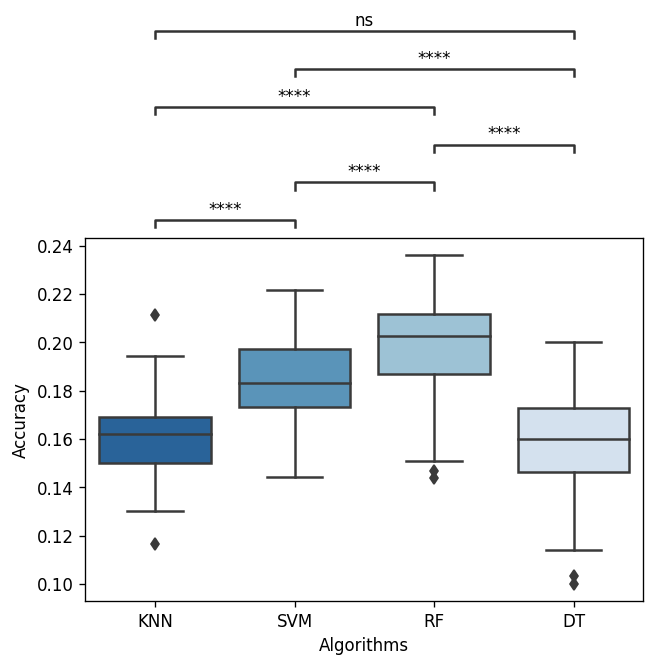

In [16]:
evaluation2(X_train, y_train, 'balanced_accuracy', "Blues_r")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KNN v.s. SVM: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.560e+03
SVM v.s. RF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.879e-08 U_stat=2.624e+03
RF v.s. DT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.158e+03
KNN v.s. RF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.574e-04 U_stat=3.279e+03
SVM v.s. DT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.128e-05 U_stat=3.049e+03
KNN v.s. DT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.499e-03 U_stat=3.620e+03


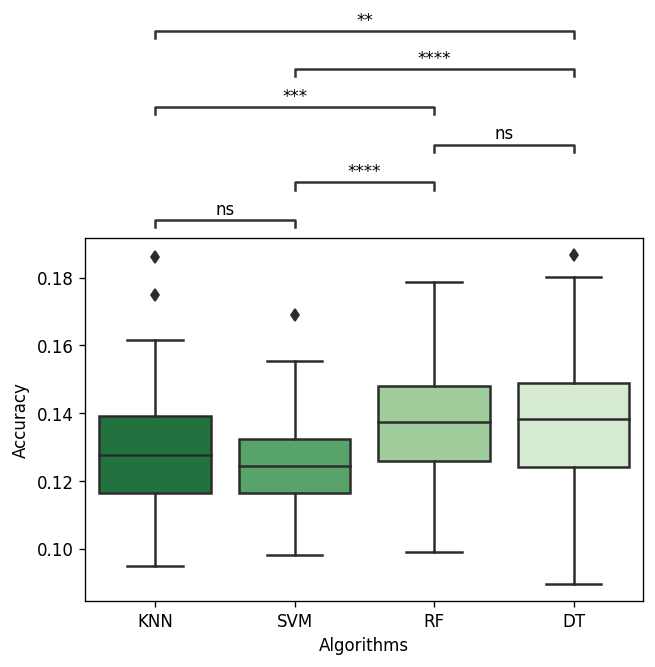

In [17]:
evaluation2(X_train_acc, y_train_acc, 'balanced_accuracy', "Greens_r")

# Base level evaluation

As we can see in the Meta level results, our best recommender is the Random Forest, so we'll be using it for the Base level evaluation.

In [18]:
#for return
rf = RandomForestClassifier(random_state=14)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

#for accuracy
rf_acc = RandomForestClassifier(random_state=14)
rf_acc.fit(X_train_acc, y_train_acc)
rf_pred_acc = rf_acc.predict(X_test_acc)

In [20]:
df = data.filter(items=y_test.index, axis=0)
df = df[['ret_ADA', 'ret_DT', 'ret_KNN', 'ret_NB', 'ret_RF', 'ret_LogReg', 'ret_SVM', 'ret_XGB']]
df.columns = ['ADA', 'DT', 'KNN', 'NB', 'RF', 'LogReg', 'SVM', 'XGB']
df

,ADA,DT,KNN,NB,RF,LogReg,SVM,XGB
1772,253.32,-2.84,167.28,-29.54,17.94,-28.92,-31.90,146.26
740,-34.19,10.35,4.79,-2.45,25.47,70.05,-147.07,15.91
1236,6.58,11.00,-44.10,55.88,-18.58,-35.70,31.78,-109.36
4156,-9.34,-2.06,-3.49,-6.10,-7.64,-3.25,9.82,0.32
2101,35.04,-0.15,20.87,-15.35,32.08,4.15,5.22,23.60
...,...,...,...,...,...,...,...,...
401,8.03,9.15,8.34,-16.03,11.88,-6.66,13.24,-8.30
4230,-2.18,6.92,1.65,-5.43,0.22,-6.01,-4.05,5.97
932,-1.34,-0.17,-8.43,-9.63,-9.47,4.86,-5.20,-8.23
1599,44.33,33.75,-3.85,12.91,53.41,58.59,-6.17,1.61


In [21]:
count = 0
ret_recom_rf = []
ret_recom_rf_acc = []
for i in y_test.index:
  pattern_rf = 'ret_' + rf_pred[count]
  ret_recom_rf.append(data[pattern_rf][i])

  pattern_rf_acc = 'ret_' + rf_pred_acc[count]
  ret_recom_rf_acc.append(data[pattern_rf_acc][i])
  
  count = count + 1

df['MetaMM(CRet)'] = ret_recom_rf  
df['MetaMM(BAC)'] = ret_recom_rf_acc 

In [22]:
df.describe()

,ADA,DT,KNN,NB,RF,LogReg,SVM,XGB,MetaMM(CRet),MetaMM(BAC)
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,41.945368,-9.058935,52.337044,116.467123,10.084077,132.746467,146.039558,71.858007,160.587792,48.541008
std,2278.218427,1100.442975,2359.793050,2499.627803,1159.973942,2343.598240,2560.506285,2273.880697,2540.799045,2257.585121
min,-26731.250000,-22236.250000,-29484.250000,-9052.800000,-26530.250000,-551.060000,-621.460000,-20682.750000,-329.400000,-20682.750000
25%,-10.040000,-12.075000,-10.390000,-8.470000,-10.280000,-4.945000,-8.705000,-10.380000,-4.100000,-9.455000
50%,0.940000,0.540000,2.210000,1.910000,1.390000,2.520000,1.290000,1.060000,5.110000,1.040000
75%,15.145000,13.300000,15.275000,14.905000,14.925000,17.980000,14.980000,13.260000,26.615000,15.400000
max,61868.400000,18119.840000,62378.160000,63034.020000,17290.880000,64435.340000,63035.340000,61775.480000,61868.400000,61868.400000


In [23]:
df.mean().sort_values(ascending=False).index

Index(['MetaMM(CRet)', 'SVM', 'LogReg', 'NB', 'XGB', 'KNN', 'MetaMM(BAC)',
       'ADA', 'RF', 'DT'],
      dtype='object')

In [24]:
melted = pd.melt(df)

melted.columns= ['Algorithms', 'Return']

melted

,Algorithms,Return
0,ADA,253.32
1,ADA,-34.19
2,ADA,6.58
3,ADA,-9.34
4,ADA,35.04
...,...,...
8825,MetaMM(BAC),8.03
8826,MetaMM(BAC),5.97
8827,MetaMM(BAC),-0.17
8828,MetaMM(BAC),44.33


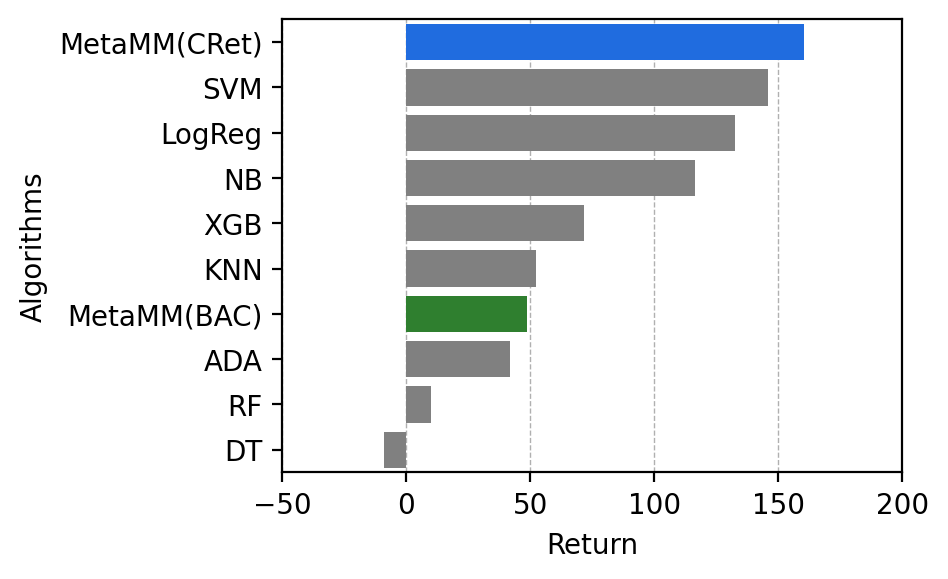

In [25]:
plt.figure(figsize=(4,3), dpi=200)
plt.grid(linestyle='--', linewidth=0.5)
sns.barplot(x="Return", y="Algorithms", data=melted, ci=None, order=df.mean().sort_values(ascending=False).index, palette=['#0066FF','grey','grey','grey','grey','grey','#228C22','grey','grey','grey']).set_axisbelow(True)
plt.xticks([-50, 0, 50, 100, 150, 200])
plt.savefig("boxplots_recom.pdf", format="pdf", bbox_inches="tight")

plt.show()